<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_MemoryIssues_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: Memory Issues (v1)
I've been having problems with System RAM escalating during training, to the point that on a normal RAM-sized platform I'm regularly failing to train to 100 epochs.

But even weirder is that the System RAM usage doesn't escalate in the same way when I switch to a High-RAM platform.

So here's some experiments to try to get to the bottom of the cause.

In [ ]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e33eb2b
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

Cloning into 'repo'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 565 (delta 36), reused 38 (delta 32), pack-reused 518 (from 1)
Receiving objects: 100% (565/565), 40.45 MiB | 21.18 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Already up to date.


<module 'slam_data' from '/content/repo/slam_data.py'>

In [ ]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
import gc
import datetime
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00


In [ ]:
# Load training data
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data4.npz')

Loaded:
  input_maps:  (1000, 159, 159, 3) x float32
  lds_maps:    (1000, 159, 159) x float32
  output_maps: (1000, 159, 159, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from repo/data/experimental-slam-training-data4.npz


In [ ]:
# Prepare static model-compatible training data
def prepare_dataset(dataset):
  N = len(dataset)
  one = next(iter(train_data))
  map_shape = one[0][0].shape
  lds_shape = one[0][1].shape
  adlo_shape = one[1][1].shape
  print(f"map_shape: {map_shape}, lds_shape: {lds_shape}, adlo_shape: {adlo_shape}")

  input_maps = np.zeros(shape=(N, map_shape[0], map_shape[1], map_shape[2]), dtype=np.float32)
  lds_inputs = np.zeros(shape=(N, lds_shape[0], lds_shape[1]), dtype=np.float32)
  output_maps = np.zeros(shape=(N, map_shape[0], map_shape[1], map_shape[2]), dtype=np.float32)
  output_adlos = np.zeros(shape=(N, adlo_shape[0]), dtype=np.float32)

  for i, ((input_map, lds_input), (output_map, output_adlo), metadata) in enumerate(dataset):
    input_maps[i] = input_map
    lds_inputs[i] = lds_input
    output_maps[i] = output_map
    output_adlos[i] = output_adlo

  return tf.data.Dataset.from_tensor_slices(((input_maps, lds_inputs), (output_maps, output_adlos)))

basic_dataset = prepare_dataset(train_data)
print(f"Returned dataset: {basic_dataset.element_spec}")

map_shape: (159, 159, 3), lds_shape: (159, 159), adlo_shape: (4,)
Returned dataset: ((TensorSpec(shape=(159, 159, 3), dtype=tf.float32, name=None), TensorSpec(shape=(159, 159), dtype=tf.float32, name=None)), (TensorSpec(shape=(159, 159, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)))


## Baseline 1
Run model with most basic settings.

In [ ]:
reload(slam)
reload(slam_data)

one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256, compile=False)
model.compile(optimizer='adam', loss={
    'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    'adlo_output': tf.keras.losses.MeanSquaredError()
})

epochs = 50
batch_size = 32
model_train_data = basic_dataset.shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")

In [ ]:
gc.collect()

110117

In [ ]:
del model_history

In [ ]:
gc.collect()

588

In [ ]:
del model

In [ ]:
gc.collect()

14809

In [ ]:
del model_train_data
gc.collect()

174

In [ ]:
del basic_dataset
del train_data
del one
gc.collect()

88

In [ ]:
%whos

Variable          Type                          Data/Info
---------------------------------------------------------
Image             module                        <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
batch_size        int                           32
cv2               module                        <module 'cv2' from '/usr/<...>ackages/cv2/__init__.py'>
datetime          module                        <module 'datetime' from '<...>/python3.10/datetime.py'>
display_history   function                      <function display_history at 0x7d6c1103bb50>
duration          float                         870.659386487
epochs            int                           50
gc                module                        <module 'gc' (built-in)>
io                module                        <module 'io' from '/usr/lib/python3.10/io.py'>
ipdb              module                        <module 'ipdb' from '/usr<...>ckages/ipdb/__init__.py'>
lds               module                   

In [ ]:
%reset -f

In [ ]:
gc.collect()

NameError: name 'gc' is not defined

**Results:**

* Started at 4.5G usage and went up to 8.1G.
* Immediate GC collect didn't recover anything of any use.
* Neither did deleting `model_history`, `model`, `model_train_data`
* I finally got a small drop from 8.2G to 7.6G after deleting all the remaining dataset copies held in memory.
* `%reset -f` cleared up about 0.4G from 7.2G to 6.8G, but it completely wiped all variables. So it amounts to restarting the system, but with less memory available afterwards.

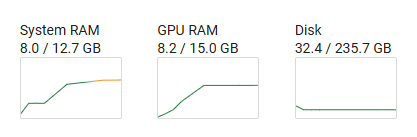

## Baseline 2
Run model with full settings.

In [ ]:
reload(slam)
reload(slam_data)

one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256, compile=True, verbose_history=True)

epochs = 50
batch_size = 32
model_train_data = train_data.map(lambda inputs, outputs, metadata: (inputs, outputs))\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

## Some other experiments


In [ ]:
# Best to run this on an entirely fresh system
import os, psutil
p = psutil.Process(os.getpid())

print("Memory Usage (before import):", p.memory_info().rss/1024/1024, "MB")

import tensorflow as tf
num_visible_gpus = 8 # OPTIONAL
gpu_devs = tf.config.experimental.list_physical_devices("GPU") # OPTIONAL
tf.config.experimental.set_visible_devices(gpu_devs[:num_visible_gpus], "GPU") # OPTIONAL

print("Memory Usage (after  import):", p.memory_info().rss/1024/1024, "MB")

tf.Variable(42.0) # Do some pseudowork...

print("Memory Usage (after var-def):", p.memory_info().rss/1024/1024, "MB")

Memory Usage (before import): 117.12109375 MB
Memory Usage (after  import): 770.2890625 MB
Memory Usage (after var-def): 872.2890625 MB


## Commentary

* https://saturncloud.io/blog/how-to-clear-jupyter-memory-without-restarting-notebook/
* https://stackoverflow.com/questions/61430162/colab-ram-is-almost-full-after-training-although-i-delete-the-variables
* https://stackoverflow.com/questions/74706189/why-is-tensorflow-putting-all-data-into-system-memory
* https://github.com/tensorflow/tensorflow/issues/36459

## Explanations

* https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth